# **Evrişimli Sinir Ağları (CNN) ile Katı Atık Tespiti**

1.) Veriyi Anlamak (Data Understanding)

2.) Veriyi Hazırlamak (Data Preparation)

3.) Modelleme (Modeling)

4.) Değerlendirme (Evaluation)

<hr>

## **1.) Veriyi Anlamak**

Bu proje kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. Stanford Üniversitesi öğrencileri tarafından hazırlanılmıştır. Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.

Görüntülerin dağılımı:


* 491 cam
* 584 kağıt
* 393 karton
* 472 plastik
* 400 metal
* 127 çöp


Görüntüler, 512 x 384 piksel boyutlarında ve 3 (RGB) kanallıdır.

### **1.1.) Gerekli Kütüphanelerin Yüklenmesi**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

# Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


### **1.2.) Veri Setinin Okunması**

In [3]:
target_size = (224, 224)

waste_labels ={'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [4]:
data_dir =  '/content/drive/MyDrive/Garbage classification'

In [5]:
def load_dataset(path, target_size, waste_labels):

    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

    Parametreler :

    path: Görsellerin bulunduğu dizini lifade eder.

    Return

    x: Görüntülere ait matris bilgilerini tutar.
    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
    """

    x = []
    labels = []

    # Gönderdiğimiz path'deki görüntüleri listeleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen path'deki görüntüler openCV kütüphanesi ile okunmaktadır.
        img = cv2.imread(image_path)

        # Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
        img = cv2.resize(img, target_size)

        # Ölçeklendirilen görüntüler x listesine eklenir.
        x.append(img)

        # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
        label = image_path.split(os.path.sep)[-2]

        # Yakalanan label'ların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key
        # değerine karşılık value değeri alınarak label oluşturulur.
        labels.append(waste_labels[label])

    # Veri seti random bir şekilde karıştırılır.
    x, labels = shuffle(x, labels, random_state=42)

    # Boyut ve Sınıf Bilgisi raporlanmaktadır.
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels


In [6]:
x, labels = load_dataset(data_dir,target_size, waste_labels)

X boyutu: (2537, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2537


In [7]:
# Görüntü Boyutlarının Tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
input_shape

(224, 224, 3)

### **1.3.) Veri Setinden Örnekler**

In [8]:
def visualize_img(image_batch, label_batch):
  """
  Veri seti içerisinden görüntü görselleştirir.

  Parametreler:

  image_batch: Görüntülere ait matris bilgilerini tutar.
  label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.

  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n] == 1][0].title())
    plt.axis('off')

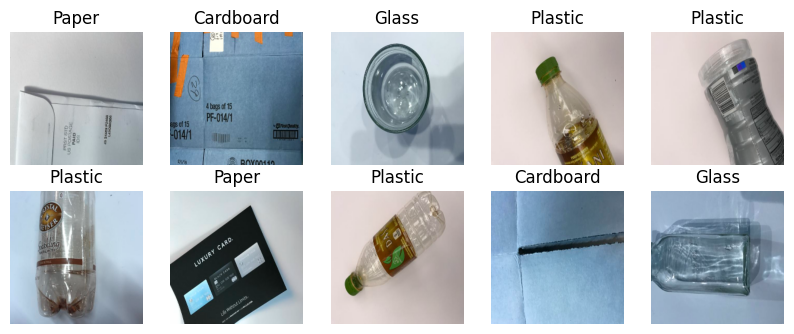

In [9]:
visualize_img(x, labels)

<hr>

## **2.) Veriyi Hazırlamak (Data Preparation)**

In [10]:
# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True, # Görüntüleri rastgele yatay olarak çevirir
                           vertical_flip=True, # Görüntüleri rastgele dikey olarak çevirir
                           validation_split=0.1, # Test veri setinin oranıdır
                           rescale=1./255, # Yeniden ölçeklendirmedir. 0-1 arasında dönüştürür.
                           shear_range = 0.1, # Görüntüye eğim vermek için kullanılır.
                           zoom_range = 0.1,
                           width_shift_range = 0.1, # Genişlik kaydırma
                           height_shift_range = 0.1) # Dikey kaydırma

# Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

Keras kütüphanesinin ImageDataGenerator sınıfını kullanarak eğitim ve test veri setleri için **veri artırma** (data augmentation) ve ölçekleme işlemleri tanımlar. Veri artırma, modelin **genelleme yeteneğini artırmak** ve **aşırı öğrenmeyi (overfitting) önlemek** için kullanılan bir tekniktir. Bu işlemler, mevcut veri setini çeşitli dönüşümlerle zenginleştirir ve modelin daha çeşitli veri üzerinde eğitilmesini sağlar.

Şimdi bunları kendi verisetimize uygulayalım.

In [11]:
train_generator=train.flow_from_directory(directory=data_dir, # Verilerin bulunduğu dizin
                                          target_size=(target_size), # Görüntülerin boyutlarını belirtirmektedir
                                          class_mode='categorical', # İlgilenilen kategorik değişkenin sınıfını ifade eder (Biz kategorikle ilgilendiğimiz için categorical)
                                                                    # eğer iki sınıflı bir problem olsaydı, class_mode olarak binary seçerdik. categorical-> 2'den fazla sınıf
                                          subset='training') # imageDataGenerator'de validation_split kullanıldıysa, verilerin alt kümesinden training veya validation belirtilimelidir.

test_generator=test.flow_from_directory(directory=data_dir,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2285 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


İlk çıktı train, ikincisi ise test içindir.

<hr>

## **3.) Modelleme**

• Sequential

• Evrişim Katmanı (Convolution Layer, Conv2D)

• Havuzlama Katmanı (Pooling Layer)

• Aktivasyon Fonksiyonu Katmanı (Activation Layer)

• Flattening Katmanı

• Dense Katmanı

• Dropout Katmanı

In [12]:
model = Sequential() # Sıralı bir model kuracağımız bilgisini programa verdik.

# Evrişim katmanı
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (input_shape), activation = 'relu'))
# Modele Conv. (evrişim) katmanları  ekliyoruz. Evrişim katmanları ile giriş görüntülerinden öznitelik çıkarımı yapılır.
# Bu katmanda çeşitli filtreler ile özellik çıkarımı yapılmaktadır. Filters = 32 -> Bir görüntü üzerinde gezinecek filtre sayısıdır.
# kernel_size, gezinecek filtrenin boyut bilgisi anlamına gelir. Padding = same, çıkış ve giriş matrislerinin boyutlarının aynı boyuta sahip olmasını sağlar.
# padding ile pixel eklenilerek bu boyut farkı ortadan kaldırılır.
# input_shape, giriş görüntülerinin boyut bilgisini temsil etmektedir. diğeri ise diğer katmana geçişte kullanılacak aktivasyon fonksiyonudur.

# Havuzlama Katmanı
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))
# Pooling, görüntünün özelliklerini kaybetmeden, boyutunu küçültme işlemidir. Herhangi bir öğrenim işlemi yapılmamaktadır.
# maxpooling, Filtrenin gezmiş olduğu noktaların max değerlerini alarak çıkış matrisi oluşturulmaktadır.
# pool_size, görüntü üzerinde gezinecek filtrenin boyut bilgisini gösterir.
# Evrişim katmanı, özellik çıkarmak için kullanılır. Bu işlem oldukça performans gerektirmektedir. Pooling ile bu performans kaybının önüne geçilir.
# yani boyut azaltmak için MaxPooling kullanılır.

# Aktivasyon fonksiyonu katmanını, yukarıda belirttik.

# Yukarıdaki katmanları, (özellikleri değişebiliriz) birden fazla kez yazabiliriz. Bu katmanlardan ne kadar oluşturmamız gerektiği ise bizim belirlememiz gereken bir Hiperparametredir.
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2,2)))


# Flattening Katmanı
model.add(Flatten())
# Yapay sinir ağları, giriş verilerini tek boyutlu bir veriden alır. Flatten ile bu verileri tek boyutlu bir diziye çeviririz.

# Dense katmanı
model.add(Dense(units = 64, activation = 'relu'))
# Katmanlar arasında düğümlerin geçişlerini sağlamaktadır. Bir katmandan aldığı nöronların, bir sonraki katmana girdi olarak bağlanmasını sağlar.

# Dropout katmanı
model.add(Dropout(rate = 0.2))
# Overfitting'in önüne geçmek için kullanılır. Sinir ağındaki nöronların kullanıcı tarafından belirlenen bir oranda rastgele söndürülmesi ile aşırı öğrenmeyi önler.
# Her iterasyonda(epoch'ta) nöronların 0.2'si rastgele sönümlenir.
# Her bir nöron, farklı bir bilgi tutmaktadır. Ağırlığı yüksek olan nöronları söndürdüğümüzde, diğer nöronların kendini gösterebileceği bir yapı oluşmaktadır.

# Bu katmanları da tekrarlayalım.
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate = 0.2))

# Çıkış katmanı
model.add(Dense(units = 6, activation = 'softmax'))
# İkiden fazla sınıf olduğu için ve sınıflandırma problemi olduğu için softmax kullanırız.

In [13]:
# Bu kod ile modelin mimari yapısını gözlemleyebiliriz.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

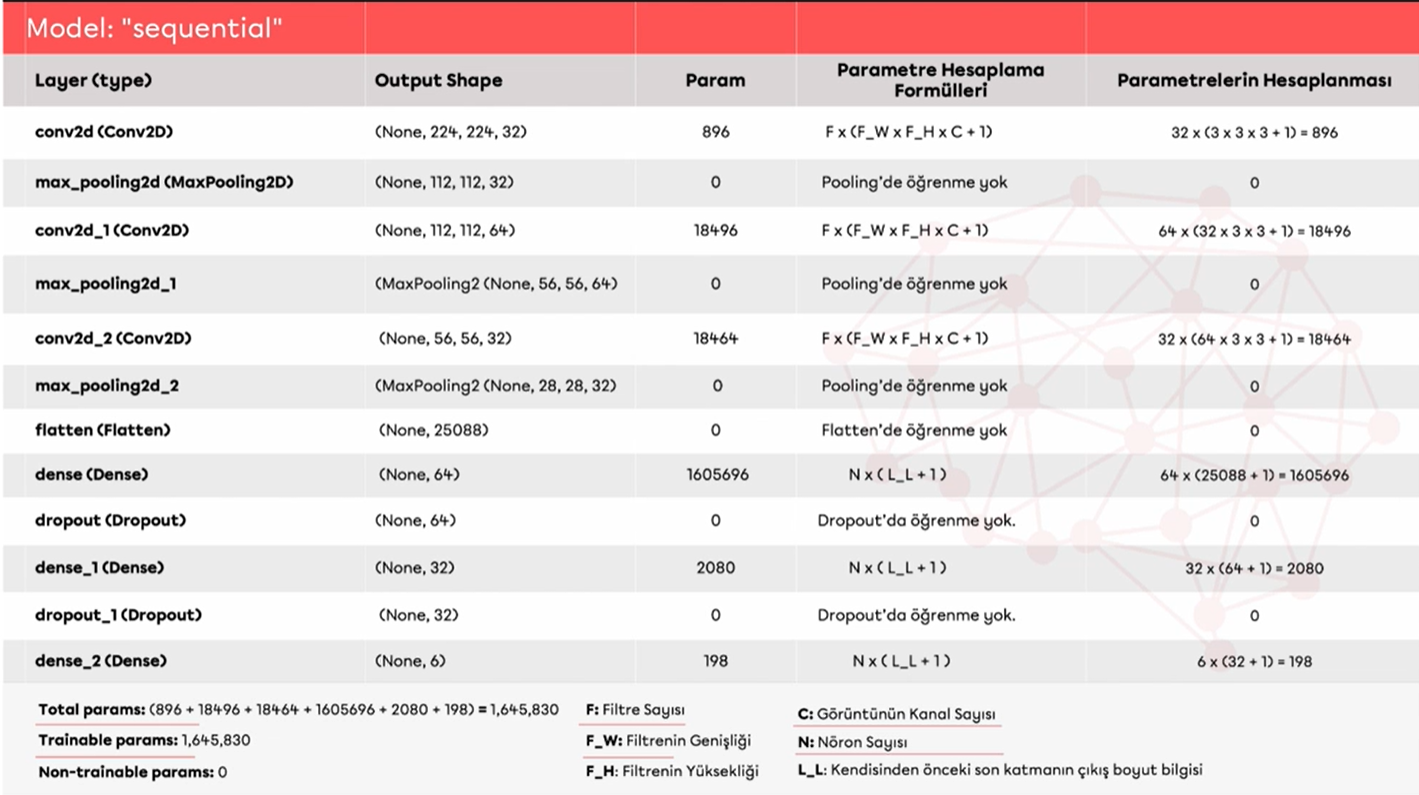

In [14]:
# Optimizer, hiperparametredir. Yine deneme yanılma yoluyla karar verilmesi gerekilir.
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [15]:
# İterasyonları ve model bilgilerini kaydetmek için bir liste oluşturalım.
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 50, verbose = 1, mode = 'min'),

             ModelCheckpoint(filepath = 'mymodel.keras', monitor = 'val_loss', mode = 'min', save_best_only = True, save_weights_only = False, verbose = 1)]

# Early Stopping
  # monitor, modelin değişimi hangi metrik üzerinden takip edileceğini belirtir.
  # patience, .. kadar epoch'ta ilerleme yaşanmazsa durmasını sağlar.
  # verbose, 0 1 2 değerlerini alabilir. 0 yazarsak, ekranda bir sonuç görmeden ilerler. 1 yazarsak, bir ilerleme bar'ı görebiliriz. 2 ise her epoch'u görebiliriz.
  # mode, model değişiminin takip edileceği parametre değerleridir. min-max-auto gibi. min modunda, takip edilen metriğin değişimi azalması durduysa sistem durur.
  # max modunda, takip edilen metriğin değişimi artması durumunda sistem durur.

# ModelCheckpoint
  # modelin nasıl kaydedileceğini isimlendiririz.
  # save_best_only True ile sadece izlenilen en iyi modelin kaydedilmesini sağlar.
  # save_weights_only True ise sadece ağırlıklarını kaydeder, False ise tüm modeli kaydeder.


In [16]:
# Modelin eğitilmesi
history = model.fit(x = train_generator,
                    epochs=90,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2285//32, # train gözlem sayısı
                    validation_steps=252//32) # test gözlem sayısı

Epoch 1/90
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - acc: 0.1995 - loss: 1.8933 - precision: 0.1496 - recall: 0.0056
Epoch 1: val_loss improved from inf to 1.58754, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 626ms/step - acc: 0.2009 - loss: 1.8893 - precision: 0.1580 - recall: 0.0059 - val_acc: 0.3373 - val_loss: 1.5875 - val_precision: 0.8000 - val_recall: 0.0635
Epoch 2/90
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.3750 - loss: 1.4840 - precision: 0.6667 - recall: 0.0625
Epoch 2: val_loss improved from 1.58754 to 1.57929, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.3750 - loss: 1.4840 - precision: 0.6667 - recall: 0.0625 - val_acc: 0.3254 - val_loss: 1.5793 - val_precision: 1.0000 - val_recall: 0.0198
Epoch 3/90
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - acc: 0.3562 - loss: 1.5691 - precision: 0.7046 - recall: 0.0746
Epoch 3: val_loss improved from 1.57929 to 1.43725, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 

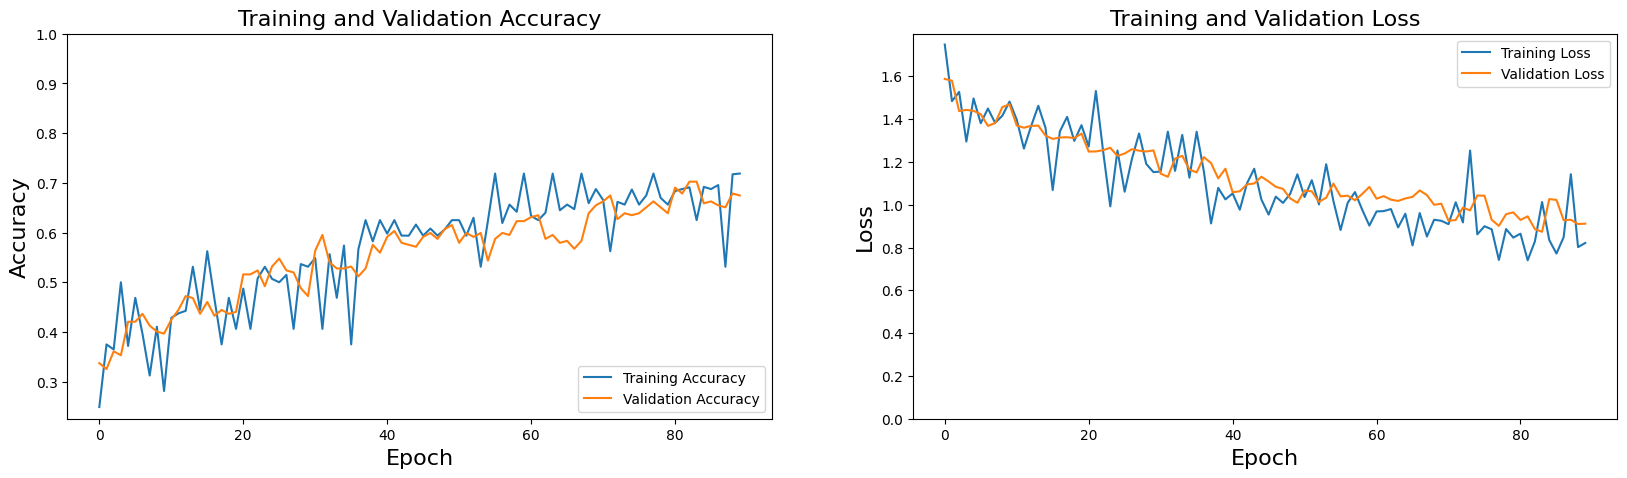

In [17]:
# Accuracy ve Loss grafikleri

# Accuracy Grafiği

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt. legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# Loss Grafiği

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt. legend (loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

Bu grafiklere göre epoch sayısının arttırıp tekrar denenebileceğini çıkarabiliriz.

<hr>

## **4.) Değerlendirme**

In [18]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size = 32)

print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.6742 - loss: 0.9125 - precision: 0.8910 - recall: 0.4874

Test accuracy: 67.5%

Test loss: 91.1%

Test precision: 89.1%

Test recall: 48.8%


Accuracy, doğru sınıflandırma oranıdır.

Precision, tahmin edilenlerin ne kadar başarılı olduğunu gösterir.

Recall, gerçek sınıfları ne kadar doğru tahmin ettiğimizi gösterir.

In [19]:
# Classification Report
x_test, y_test = next(test_generator)
y_pred = model.predict(x_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


In [20]:
# Her sınıfın olasılık değerleri dönecektir.
y_pred

array([[1.41439974e-04, 9.44428146e-01, 1.46166906e-02, 3.19431570e-06,
        4.07900773e-02, 2.05747147e-05],
       [1.47547275e-02, 5.07840693e-01, 5.23915663e-02, 6.14494868e-02,
        3.54170918e-01, 9.39267967e-03],
       [4.36175972e-01, 3.81591879e-02, 2.80748785e-01, 6.92927465e-02,
        1.06260814e-01, 6.93624914e-02],
       ...,
       [1.70140460e-01, 2.74248034e-01, 1.56360388e-01, 1.99619681e-02,
        3.09156597e-01, 7.01325908e-02],
       [2.24275570e-02, 7.20420629e-02, 2.68641021e-02, 7.23237216e-01,
        1.22910939e-01, 3.25180329e-02],
       [2.55004577e-02, 1.34099528e-01, 5.05194589e-02, 4.56276268e-01,
        2.89385021e-01, 4.42192666e-02]], dtype=float32)

Bize hangi sınıfı tahmin ettiği gerekmektedir.
Bunu da argmax fonksiyonu ile görebiliriz.

In [21]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [22]:
# Hedef değişkenin sınıflarının isimlerine erişelim.
target_names = list(waste_labels.keys())

In [23]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   cardboard       0.71      0.68      0.69        40
       glass       0.69      0.66      0.67        50
       metal       0.58      0.68      0.63        41
       paper       0.84      0.86      0.85        59
     plastic       0.67      0.46      0.54        48
       trash       0.35      0.62      0.44        13

    accuracy                           0.67       251
   macro avg       0.64      0.66      0.64       251
weighted avg       0.69      0.67      0.67       251



In [24]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')


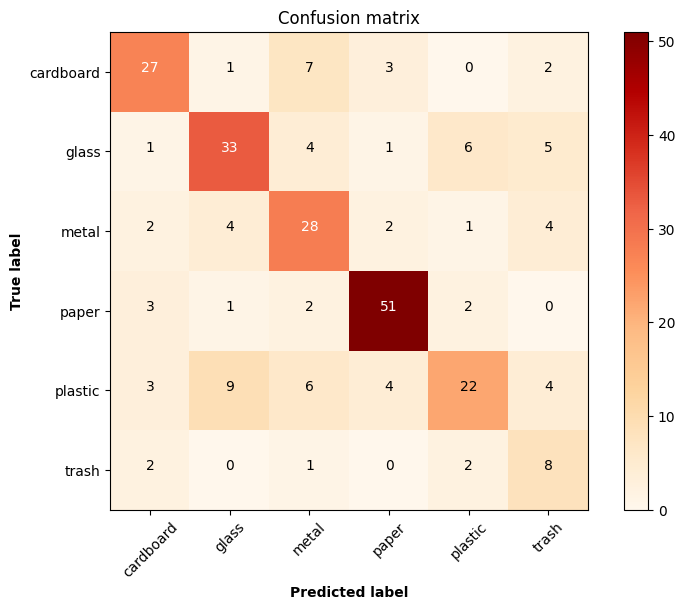

In [25]:
# Karışıklık matrisi çizimi
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)


In [29]:
from keras.preprocessing import image

In [30]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

def model_testing(path):
    '''
    Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduğuna dair tahmin işlemi gerçekleştirilir.

    Parametreler:
    path: Görsellerin bulunduğu dizini ifade eder.

    Return:
    img: Görüntü
    p: Tahmin olasılıkları
    predicted_class: Tahmin sınıfı
    '''
    img = image.load_img(path, target_size=(target_size))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])

    return img, p, predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


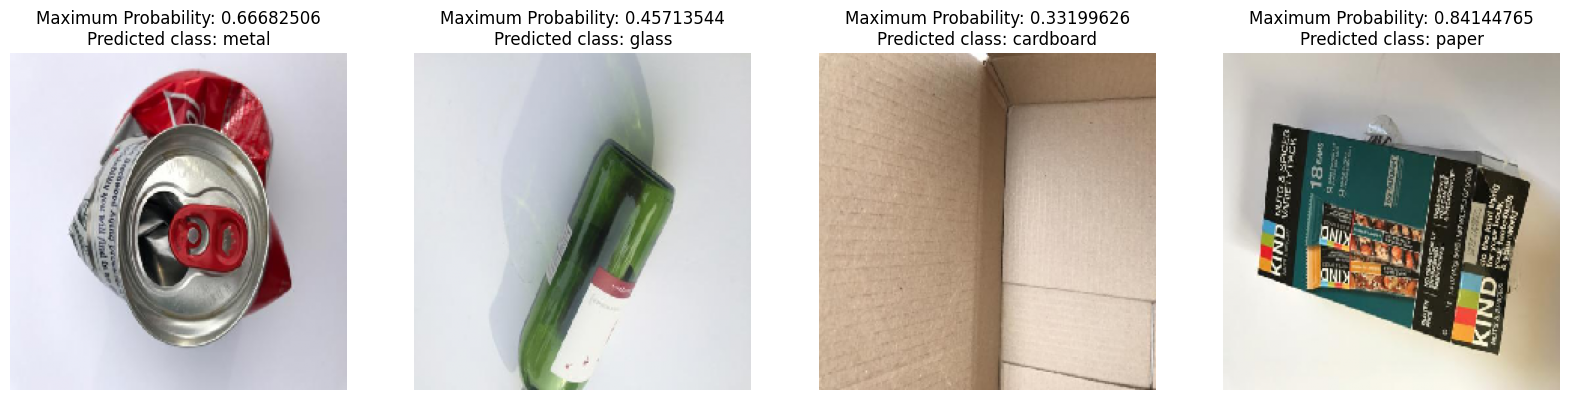

In [31]:
img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage classification/metal/metal100.jpg')
img2, p2, predicted_class2 = model_testing('/content/drive/MyDrive/Garbage classification/glass/glass105.jpg')
img3, p3, predicted_class3 = model_testing('/content/drive/MyDrive/Garbage classification/cardboard/cardboard103.jpg')
img4, p4, predicted_class4 = model_testing('/content/drive/MyDrive/Garbage classification/paper/paper106.jpg')

plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class2]))
plt.imshow(img2)

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class3]))
plt.imshow(img3)

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class4]))
plt.imshow(img4)

plt.show()
